In [119]:
# Import necessary libraries
from dataframe_utils import * # this imports all the functions from our dataframe_utils including all the imports
from plotting_utils import * # this imports all the functions from our plotting_utils
import plotting_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
csv_file = '202407_model6_processed_20240807_182231'
run_name = '202407'
model = 'model6'

In [121]:
df = pd.read_csv(f'../{run_name}/data/{csv_file}.csv')
df["time_of_day"] = df["time_of_day"].astype('datetime64[ns]')
start_frame = df["time_of_day"].min()
df['dpf'] = df["dpf"] 

# Mom data
### filter out only mom data

In [122]:
mom_face = df[df['class']=='mom_face']
mom_pectoral_fin = df[df['class']=='pectoral_fin']
mom = mom_face.append(mom_pectoral_fin)
mom = mom[mom["confidence"] >= 0.6]

C:\Users\ashparker\AppData\Local\Temp\ipykernel_14048\3505928186.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom = mom_face.append(mom_pectoral_fin)


In [ ]:
## For clucth swap 202208_cam2
# mom["dpf"] = mom["dpf"] + 5

## Extract ROI column (single df) 

#### Load ROI json file

In [123]:
ROI_file_path = f'../{run_name}/data/{run_name}_mom.json'
ROI_dict = get_ROI_dict(ROI_file_path)

#### Plot ROIs on frame
##### Check if ref frame is .JPEG or .jpeg and change accordingly

In [124]:
# define a function to plot our ROIs on the background frame (as a sanity check)
from matplotlib.patches import PathPatch

reference_frame_path = f'../{run_name}/data/{run_name}_reference_frame.JPEG'
backgd_img = plt.imread(reference_frame_path) # load backround frame to plot ROIs on
def plot_chambers(polygons_dict):
    fig, ax = plt.subplots(1, 1)

    ax.imshow(backgd_img, cmap='gray')

    for roi_label, roi_polygon in polygons_dict.items():
        patch = PathPatch(roi_polygon, facecolor='blue', lw=1, alpha=0.4)
        ax.text(*np.mean(roi_polygon.vertices, axis=0), roi_label, color='white', size='small')
        ax.add_patch(patch)
    plt.xticks([])
    plt.yticks([])
    plt.show()

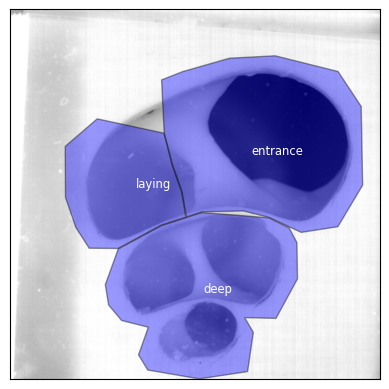

In [125]:
plot_chambers(ROI_dict)

In [126]:
backgd_img.shape

(2048, 2048)

In [127]:
# get the width and height of the frame
# add ",c" to height, width in first line if error occurs (for colour images - third dimension is colour)
height, width= backgd_img.shape
# this is needed as our position coordinates are normalized between 0 and 1 while our ROI coordinates are not
height, width

(2048, 2048)

In [128]:
# apply the above function to the x and y coordinates in each row of our larvae dataframe
mom = add_ROI_col(mom, width, height, ROI_dict)

## Extract ROI column (split dfs) (202007, 202208_cam?)

INPUT: the first good frame after the split

In [ ]:
time_of_split_str="20240518_085605"
mom_before_split, mom_after_split = split_df_at_time(mom, time_of_split_str)

In [ ]:
# Sanity check: Make sure the sum of the lengths of the 2 splits equals the original dataframe length
print(len(mom) == (len(mom_before_split)+len(mom_after_split)))

### Extract and adjust DPF column

Make changes: change green number addition to the after split depending on age of clutch at split

In [ ]:
mom_before_split= add_dpf_col_human_time(mom_before_split)
mom_after_split= add_dpf_col_human_time(mom_after_split)

mom_before_split["dpf"] = mom_before_split["dpf"] + 2
mom_after_split["dpf"] = mom_after_split["dpf"] + 6

Sanity checks:

In [ ]:
print(mom_before_split["dpf"] .min())
print(mom_before_split["dpf"] .max())
print(mom_after_split["dpf"] .min())
print(mom_after_split["dpf"] .max())

### Extract ROI column

#### Load ROI json file

Data before the split:

In [ ]:
ROI_file_path_before = f'../{run_name}/data/{run_name}_1_mom.json'
ROI_dict_before = get_ROI_dict(ROI_file_path_before)

reference_frame_path_before = f'../{run_name}/data/{run_name}_reference_frame_1.jpeg'
backgd_img_before = plt.imread(reference_frame_path_before)

Data after the split:

In [ ]:
ROI_file_path_after = f'../{run_name}/data/{run_name}_2_mom.json'
ROI_dict_after = get_ROI_dict(ROI_file_path_after)

reference_frame_path_after = f'../{run_name}/data/{run_name}_reference_frame_2.jpeg'
backgd_img_after = plt.imread(reference_frame_path_after)

#### Plot ROIs on frame

In [ ]:
from matplotlib.patches import PathPatch

def plot_chambers(polygons_dict, backgd_img):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    
    ax.imshow(backgd_img, cmap='gray')

    for roi_label, roi_polygon in polygons_dict.items():
        patch = PathPatch(roi_polygon, facecolor='blue', lw=1, alpha=0.2)
        ax.text(*np.mean(roi_polygon.vertices, axis=0), roi_label, color='white', size='small')
        ax.add_patch(patch)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
plot_chambers(ROI_dict_before, backgd_img_before)
plot_chambers(ROI_dict_after, backgd_img_after)

In [ ]:
# get the width and height of the frame
height, width, channel = backgd_img_before.shape
# this is needed as our position coordinates are normalized between 0 and 1 while our ROI coordinates are not
height, width

In [ ]:
# apply the above function to the x and y coordinates in each row of our larvae dataframe
mom_before_split = add_ROI_col(mom_before_split, width, height, ROI_dict_before)
mom_after_split = add_ROI_col(mom_after_split, width, height, ROI_dict_after)

### Merge back the split tables

In [ ]:
# check: this should be the clutch exchange interval/ disruption interval. NB: these shouldn't have a temporal overlap
print(mom_before_split["time_of_day"].max())
print(mom_after_split["time_of_day"].min())

In [ ]:
mom = mom_before_split.append(mom_after_split)

## Ensuring one chamber per mom-visit
### - Filter out multiple mom faces and chose face over pectoral fin where possible

In [129]:
idx = mom.groupby(['time_of_day', 'class'])['confidence'].transform(max) == mom['confidence']
mom_filtered = mom[idx]

In [130]:
idx2 = mom_filtered.groupby(['time_of_day'])['class'].transform(min) == mom_filtered['class']
mom_filtered2 = mom_filtered[idx2]

In [131]:
def determine_mom_position(x):
    if x["class"] == "mom_face":
        return x
    else:
        pectoral_fin_chamber = x["ROI"]
        if pectoral_fin_chamber == "entrance":
            x["ROI"] = "laying"
        elif pectoral_fin_chamber == "laying":
            x["ROI"] = "deep"
        return x

In [132]:
mom_filtered2 = mom_filtered2.apply(determine_mom_position, axis=1)

In [133]:
# Sanity check
print(len(df))
print(len(mom))
print(len(mom_filtered))
print(len(mom_filtered2))

42810
1716
1294
676


In [134]:
mom_table = pd.pivot_table(mom_filtered2, values='frame', index=['time_of_day', 'dpf'],
                    columns=['ROI'], aggfunc="count", fill_value=0)
mom_table.reset_index(inplace=True)
mom_table = mom_table.rename_axis(None, axis=1)
mom_table

,time_of_day,dpf,deep,entrance,laying
0,2024-07-16 07:47:40,0,1,0,0
1,2024-07-16 08:56:05,0,1,0,0
2,2024-07-16 09:03:06,0,1,0,0
3,2024-07-16 09:10:07,0,1,0,0
4,2024-07-16 09:17:08,0,1,0,0
...,...,...,...,...,...
671,2024-07-23 06:37:30,7,0,1,0
672,2024-07-23 06:44:31,7,0,1,0
673,2024-07-23 06:51:32,7,0,1,0
674,2024-07-23 06:58:33,7,0,1,0


## Create Plots

### Vertical Line Plot

#### Normal dfs

In [ ]:
fig_vertical_line_plot = plot_vertical_line_plot(mom_table, mom)
ax = fig_vertical_line_plot.axes[0]

# fresh water added
# momectomy
plt.arrow(dt.datetime(year=2024, month=4, day=29, hour=13, minute=55, second=23),3.5, 0, -0.5, color='blue',length_includes_head=False,head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=4, day=30, hour=10, minute=21, second=00),3.5, 0, -0.55, color='orange',length_includes_head=True, head_width=0.1, head_length=0.03)

plt.show()

In [ ]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_mom_chamberplot_YOLO_{timestamp_now}.pdf'
save_figure(fig_vertical_line_plot, figure_path)

#### Momectomies or missing mom days

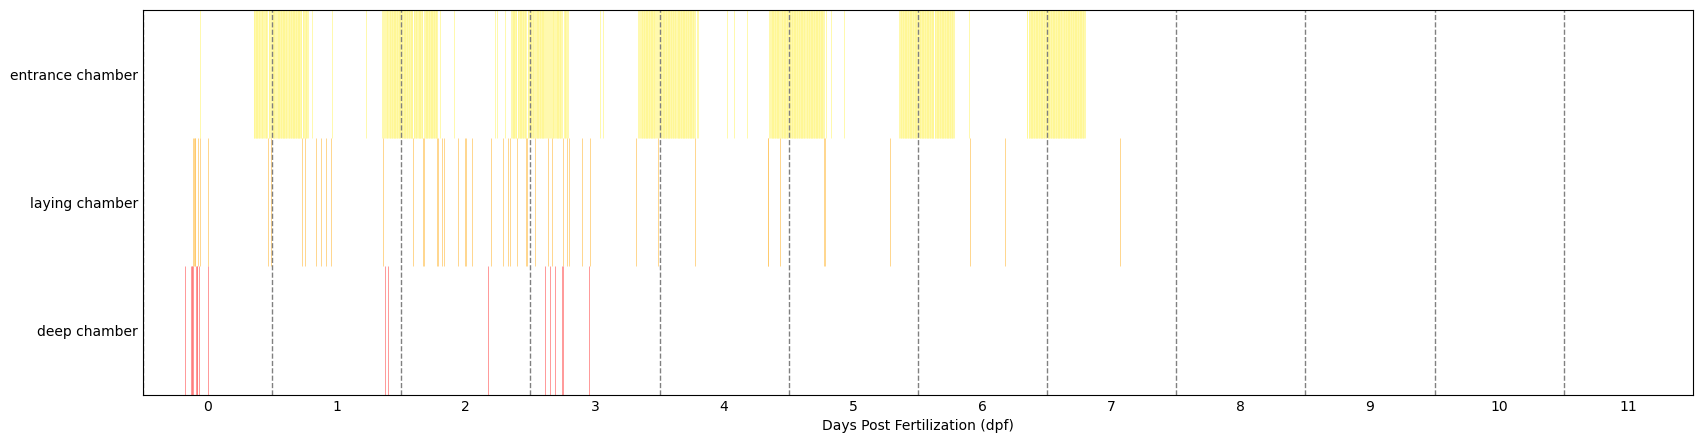

In [135]:
fig_vertical_line_plot = plot_vertical_line_plot(mom_table, mom, max_dpf=11)

ax = fig_vertical_line_plot.axes[0]
# fresh water added
# momectomy
plt.arrow(dt.datetime(year=2024, month=4, day=29, hour=13, minute=55, second=23),3.5, 0, -0.5, color='blue',length_includes_head=False,head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=4, day=30, hour=10, minute=21, second=00),3.5, 0, -0.55, color='orange',length_includes_head=True, head_width=0.1, head_length=0.03)

plt.show()

In [136]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_mom_chamberplot_YOLO_{timestamp_now}.pdf'
save_figure(fig_vertical_line_plot, figure_path)

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_mom_chamberplot_YOLO_20240807_183943.pdf


#### 202107 missing data

In [ ]:
#202107 only
max_dpf=11
fig_vertical_line_plot = plot_vertical_line_plot(mom_table, mom_filtered2, max_dpf)
ax = fig_vertical_line_plot.axes[0]
ax.axvline(dt.datetime(year=2021, month=7, day=1, hour=0, minute=0, second=0), color='grey',linestyle='--', linewidth=1)
correct_dpfs = []
for i in range(max_dpf + 1):
   x = dt.datetime(year=2021, month=6, day=25, hour=12, minute=0, second=0)+ dt.timedelta(hours=24 * i)
   correct_dpfs.append(x)
ax.set_xticks(correct_dpfs)
ax.set_xticklabels(range(max_dpf + 1))

#Any markers needed?
#3:55 02.07.2021 momectomy
plt.arrow(dt.datetime(year=2021, month=7, day=2, hour=15, minute=55, second=0),3.5, 0, -0.6, color='orange',length_includes_head=True, head_width=0.5, head_length=0.3)

plt.show()

In [ ]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_mom_chamberplot_YOLO_{timestamp_now}.pdf'
save_figure(fig_vertical_line_plot, figure_path)

## Finding night and day times

In [150]:
#Finding when night starts
extra_df = mom_table[mom_table['dpf'] == 7]
# extra_column - extra_column.shift(periods=1, fill_value=0)
extra_df['differences'] = (extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=1, fill_value=0))
extra_df.sort_values(by=['differences'])

C:\Users\ashparker\AppData\Local\Temp\ipykernel_14048\2991442501.py:4: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  extra_df['differences'] = (extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=1, fill_value=0))
C:\Users\ashparker\AppData\Local\Temp\ipykernel_14048\2991442501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_df['differences'] = (extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=1, fill_value=0))


,time_of_day,dpf,deep,entrance,laying,differences
643,2024-07-23 03:21:00,7,0,1,0,0 days 00:07:00
642,2024-07-23 03:14:00,7,0,1,0,0 days 00:07:00
674,2024-07-23 06:58:33,7,0,1,0,0 days 00:07:01
647,2024-07-23 03:49:05,7,0,1,0,0 days 00:07:01
648,2024-07-23 03:56:06,7,0,1,0,0 days 00:07:01
649,2024-07-23 04:03:07,7,0,1,0,0 days 00:07:01
650,2024-07-23 04:10:08,7,0,1,0,0 days 00:07:01
651,2024-07-23 04:17:09,7,0,1,0,0 days 00:07:01
652,2024-07-23 04:24:10,7,0,1,0,0 days 00:07:01
653,2024-07-23 04:31:11,7,0,1,0,0 days 00:07:01


In [151]:
#Finding when day starts
extra_df = mom_table[mom_table['dpf'] == 7]
# extra_column - extra_column.shift(periods=1, fill_value=0)
extra_df['differences'] = abs(extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=-1, fill_value=0))
extra_df.sort_values(by=['differences'])

C:\Users\ashparker\AppData\Local\Temp\ipykernel_14048\1516510019.py:4: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  extra_df['differences'] = abs(extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=-1, fill_value=0))
C:\Users\ashparker\AppData\Local\Temp\ipykernel_14048\1516510019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_df['differences'] = abs(extra_df['time_of_day'] - extra_df['time_of_day'].shift(periods=-1, fill_value=0))


,time_of_day,dpf,deep,entrance,laying,differences
642,2024-07-23 03:14:00,7,0,1,0,0 days 00:07:00
641,2024-07-23 03:07:00,7,0,1,0,0 days 00:07:00
644,2024-07-23 03:28:01,7,0,1,0,0 days 00:07:01
671,2024-07-23 06:37:30,7,0,1,0,0 days 00:07:01
646,2024-07-23 03:42:04,7,0,1,0,0 days 00:07:01
647,2024-07-23 03:49:05,7,0,1,0,0 days 00:07:01
648,2024-07-23 03:56:06,7,0,1,0,0 days 00:07:01
649,2024-07-23 04:03:07,7,0,1,0,0 days 00:07:01
650,2024-07-23 04:10:08,7,0,1,0,0 days 00:07:01
651,2024-07-23 04:17:09,7,0,1,0,0 days 00:07:01


## Visitation frequency plot

#### Add day/night column

In [137]:
mom_filtered2['day_night'] = mom_filtered2['time_of_day'].apply(lambda x: 'day' if  7 <= x.hour <= 20  else "night")
mom_filtered2['dpf']=mom_filtered2['dpf']

In [138]:
# note (fyi): used class but could have used any column name
visitation_counts = mom_filtered2.groupby(['dpf', 'day_night'], as_index= False)['class'].count()
visitation_counts

,dpf,day_night,class
0,0,day,22
1,0,night,23
2,1,day,12
3,1,night,81
4,2,day,21
5,2,night,84
6,3,day,14
7,3,night,83
8,4,day,11
9,4,night,83


In [139]:
visitation_counts.to_csv(f'../{run_name}/data/{run_name}_mom_visitation.csv', index=False)

In [ ]:
# # TO LOAD IN visitation_counts
# run_name= '202209'
# visitation_counts = pd.read_csv(f'../{run_name}/data/{run_name}_mom_visitation.csv')

In [140]:
# number of frames per day
# Group the DataFrame by the 'dpf' column and then find the maximum 'day_slice' value in each group
max_day_slice_per_dpf = mom_filtered2.groupby('dpf')['day_slice'].max()

# This will give you a Series where the index is 'dpf' values and the values are the maximum 'day_slice' values for each 'dpf'.
print(max_day_slice_per_dpf)

dpf
0    128
1    201
2    201
3    201
4    201
5    201
6    201
7    114
Name: day_slice, dtype: int64


#### Separate day and night into two lists 

In [141]:
# action: hash out night for old no-night data
day_counts = visitation_counts[visitation_counts["day_night"] == "day"]["class"].tolist()
night_counts = visitation_counts[visitation_counts["day_night"] == "night"]["class"].tolist()

In [142]:
# Convert frame number to proportion of frames:
day_counts_norm = []
for day in day_counts:
    proportion = day/120
    day_counts_norm.append(proportion)

night_counts_norm = []
for night in night_counts:
    proportion = night/85
    night_counts_norm.append(proportion)

#### Insert "0" in missing days (if needed)

In [ ]:
# action: only run this if days/nights are missing (ctr ? to hash/ unhash)
# day_counts_norm.insert(0,0)
# day_counts_norm.insert(1,0)
# day_counts_norm.insert(2,0)
# day_counts_norm.insert(3,0)
# day_counts_norm.insert(4,0)
# day_counts_norm.insert(5,0)
# day_counts_norm.insert(6,0)
day_counts_norm.insert(7,0)
# day_counts_norm.insert(8,0)
# day_counts_norm.insert(9,0)
# day_counts_norm.insert(10,0)
# day_counts_norm.insert(11,0)
# day_counts_norm.insert(12,0)

# night_counts_norm.insert(0,0)
# night_counts_norm.insert(1,0)
# night_counts_norm.insert(2,0)
# night_counts_norm.insert(3,0)
# night_counts_norm.insert(4,0)
# night_counts_norm.insert(5,0)
# night_counts_norm.insert(6,0)
# night_counts_norm.insert(7,0)
# night_counts_norm.insert(8,0)
# night_counts_norm.insert(9,0)
# night_counts_norm.insert(10,0)
# night_counts_norm.insert(11,0)
# night_counts_norm.insert(12,0)

### Visitation plot

In [ ]:
# hash out night for old data
print(len(day_counts_norm))
print(len(night_counts_norm))

In [143]:
# Setting for all plots: 

labels = range(max(visitation_counts['dpf'])+1)
bar_width = 0.8 
ax.set_xlim(-0.5,12.5)
print(len(labels))

8


#### Day visits

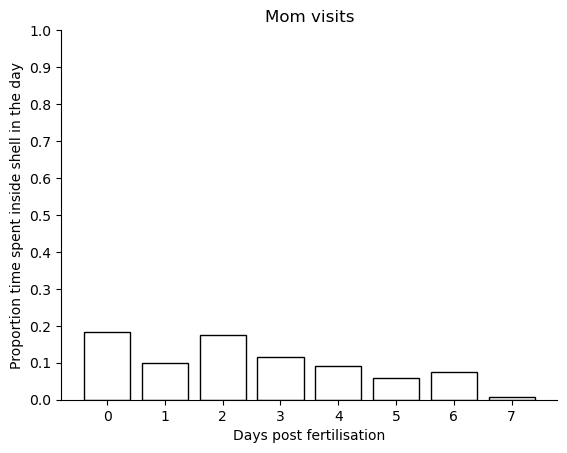

In [144]:
fig, ax = plt.subplots()

ax.bar(labels, day_counts_norm, bar_width, label='day', color='white', edgecolor='black')
ax.set_xticks(labels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_yticks([i/10 for i in range(11)])
ax.set_ylabel('Proportion time spent inside shell in the day')
ax.set_xlabel('Days post fertilisation')
ax.set_title('Mom visits')

plt.show()

In [145]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_day_visitation_{timestamp_now}.pdf'

# save figure (either as png or pdf)
fig.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_day_visitation_20240807_184026.pdf


#### Night visits

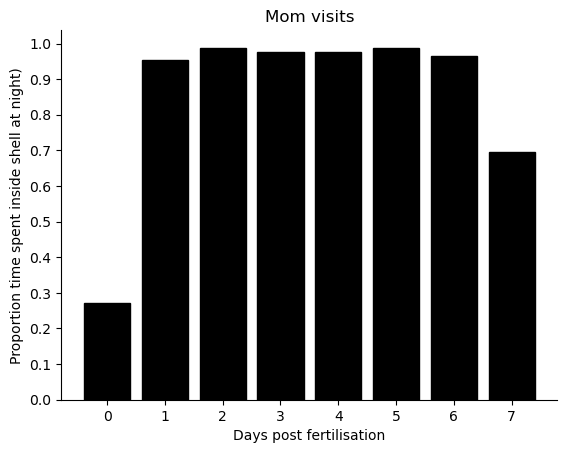

In [146]:
# for when day and night counts exist
fig, ax = plt.subplots()

ax.bar(labels, night_counts_norm, bar_width, color='black', edgecolor='Black')
ax.set_xticks(labels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_yticks([i/10 for i in range(11)])
ax.set_ylabel('Proportion time spent inside shell at night)')
ax.set_xlabel('Days post fertilisation')
ax.set_title('Mom visits')

plt.show()

In [147]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_night_visitation_{timestamp_now}.pdf'

# save figure (either as png or pdf)
fig.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_night_visitation_20240807_184035.pdf


#### Visitation Day/Night plot

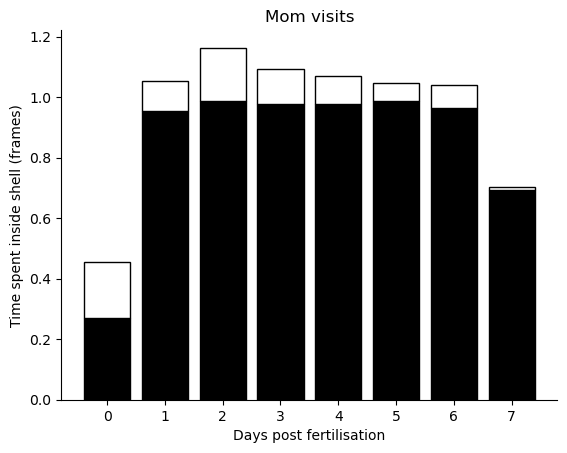

In [148]:
# for when day and night counts exist
fig, ax = plt.subplots()

ax.bar(labels, night_counts_norm, bar_width, label='night', color='black', edgecolor='black')
ax.bar(labels, day_counts_norm, bar_width, bottom=night_counts_norm, label='day', color='white', edgecolor='black')
ax.set_xticks(labels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_ylabel('Time spent inside shell (frames)')
ax.set_xlabel('Days post fertilisation')
ax.set_title('Mom visits')

plt.show()

In [149]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_visitation_daynight_{timestamp_now}.pdf'

# save figure (either as png or pdf)
fig.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_visitation_daynight_20240807_184038.pdf


### Dot Plot

In [ ]:
# We need the xy coordinates and the reference figure (variable backgd_img)

reference_frame_path = f'../{run_name}/data/{run_name}_reference_frame.JPEG'
backgd_img = plt.imread(reference_frame_path) # load backround frame to plot ROIs on
height, width = backgd_img.shape

xpos_unnormalized = np.array(mom_filtered2['xcenter_normalized'])*width
ypos_unnormalized = np.array(mom_filtered2['ycenter_normalized'])*height

plt.imshow(backgd_img, cmap='gray')
# TODO : add custom colorbar to explain the meaning of the color
plt.scatter(xpos_unnormalized, ypos_unnormalized, s=0.1, c=mom_filtered2['time_of_day'], cmap = "viridis_r" )
plt.colorbar()
plt.xticks([])
plt.yticks([])
figure = plt.gcf()
plt.show()

##### Save figure 

In [ ]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_dotplot_mom_{timestamp_now}.pdf'

# save figure (either as png or pdf)
figure.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))
# Change to date and time I think